In [ ]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

import dill                        
filename = 'Prediction.Methylation.ipynb.pkl'
dill.dump_session(filename)
# dill.load_session(filename)

#### Senescence based transcriptome

In [ ]:
# GSE98440
df = pd.read_csv('../ImmunotherapyAnalysis/Transcriptome/Senescence/GSE98440_norm_counts_IMR90pro_sen.csv.gz', sep='\t', low_memory=False)
GeneSymbols = pd.read_csv('../ImmunotherapyAnalysis/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')
df.index = df['Unnamed: 0'].map(GeneSymbols.dropna(subset='EnsemblGeneID').set_index('EnsemblGeneID')['Symbol'].to_dict())
df = df.drop('Unnamed: 0', axis=1).iloc[:-1,:]
df = df[~ df.index.isna()]
df.T.to_pickle('../ImmunotherapyAnalysis/Transcriptome/GSE98440.Senescence.pkl')

/tmp/ipykernel_1721370/1457257856.py:2: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  GeneSymbols = pd.read_csv('../ImmunotherapyAnalysis/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')


In [ ]:
# GSE63577
df = pd.read_csv('../ImmunotherapyAnalysis/Transcriptome/Senescence/GSE63577_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz', sep='\t')
df['GeneID'] = df['GeneID'].map(GeneSymbols.set_index('GeneID')['Symbol']).values
df.set_index('GeneID', inplace=True)
df = df.T

In [ ]:
dfMeta = pd.read_table('../ImmunotherapyAnalysis/Transcriptome/Senescence/GSE63577_series_matrix.txt', sep='	').T
dfMeta.columns = dfMeta.iloc[:1,:].values[0]
dfSen = df.index.map(dfMeta.set_index(' Sample_geo_accession')[' Sample_characteristics_ch1'].iloc[1:,:1].to_dict()[' Sample_characteristics_ch1'])
df['Senescence'] = dfSen.str.replace('population doublings: ','').astype(int).map(lambda x: 0 if x <= 35 else (1 if x > 52 else np.nan))
df = df.dropna()

In [ ]:
# df.drop('Senescence', axis=1).to_pickle('../ImmunotherapyAnalysis/Transcriptome/GSE63577.Senescence.pkl')
df[['Senescence']].to_csv('../ImmunotherapyAnalysis/Transcriptome/GSE63577.Labels.csv')

### Senescence biomarkers

In [ ]:
import glob
AllCpgs = glob.glob("GSE98440/*.csv")

GSE98440Meth = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GSE98440Meth = pd.concat([GSE98440Meth, newCSV],axis=1)
    except:pass
GSE98440Meth = GSE98440Meth.loc[:,~GSE98440Meth.columns.duplicated()].copy()
GSE98440Meth = GSE98440Meth.set_index('Unnamed: 0')
GSE98440Meth = np.clip(GSE98440Meth, 0,1)

In [ ]:
X = scaler.fit_transform(GSE98440Meth)
y = GSE98440Meth.index.map(lambda x: 1 if 'sen' in x else 0).values

In [ ]:
model = LogisticRegression(random_state=42, n_jobs=-1,penalty='l1', solver='saga', tol=1000)
model.fit(X,y)

LogisticRegression(n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                   tol=1000)

In [ ]:
SenescentCPGs = pd.DataFrame(model.coef_[0], index=GSE98440Meth.columns)
SenescentCPGs = SenescentCPGs[SenescentCPGs[0] != 0]
SenescentCPGs = SenescentCPGs.loc[SenescentCPGs[0].abs().sort_values(ascending=False).index]

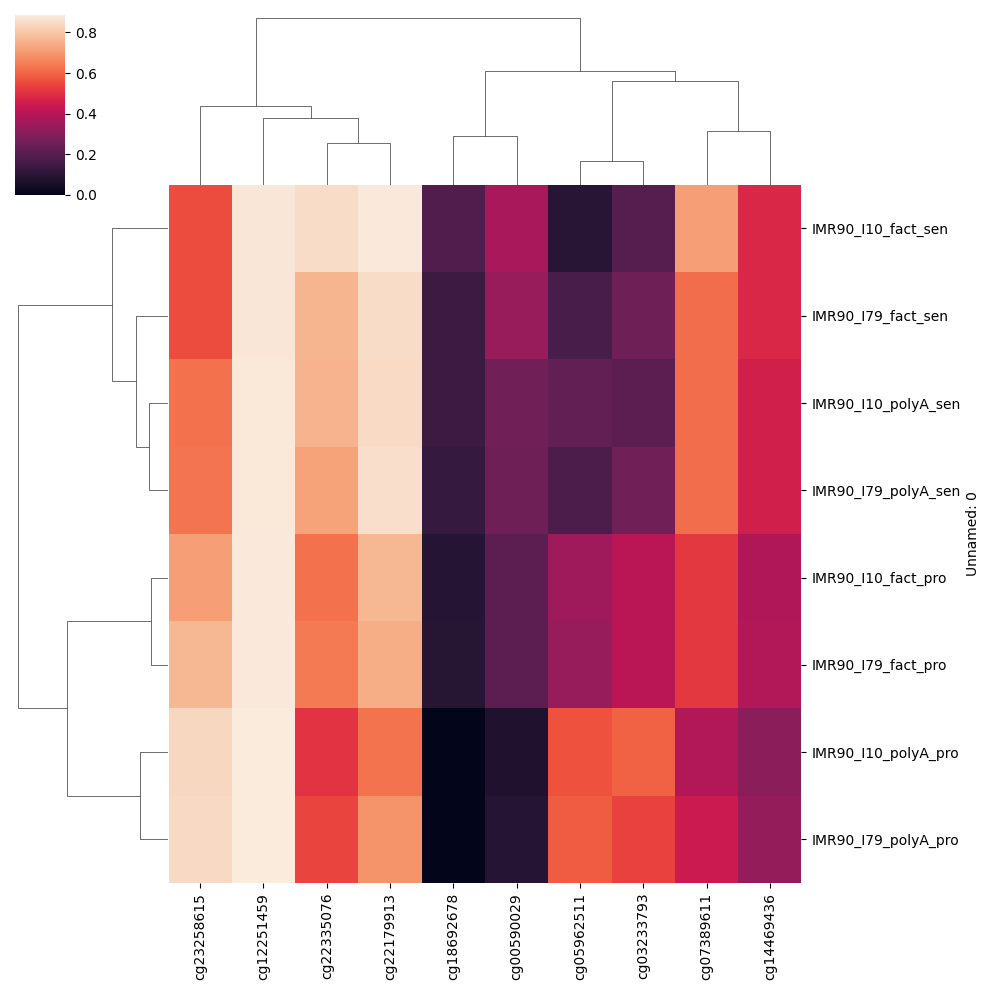

In [ ]:
sns.clustermap(GSE98440Meth[SenescentCPGs.head(10).index])

In [ ]:
commomCPGs = GSE91069SenVal.columns.intersection(GSE63577Meth.columns)

In [ ]:
import glob
AllCpgs = glob.glob("GSE63577/*.csv")

GSE63577Meth = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GSE63577Meth = pd.concat([GSE63577Meth, newCSV],axis=1)
    except:pass
GSE63577Meth = GSE63577Meth.loc[:,~GSE63577Meth.columns.duplicated()].copy()
GSE63577Meth = GSE63577Meth.set_index('Unnamed: 0')
GSE63577Meth = np.clip(GSE63577Meth, 0,1)

In [ ]:
X = scaler.fit_transform(GSE63577Meth[commomCPGs])
GSE63577MethLabels = pd.read_csv('Transcriptome/GSE63577.Labels.csv')['Senescence']
y = GSE63577MethLabels.copy()

In [ ]:
model = LogisticRegression(random_state=42, n_jobs=-1,penalty='l1', solver='saga', tol=1000)
print(cross_val_score(model, X, y, scoring='f1_micro',cv=5,))
model.fit(X,y)

[1.         1.         0.85714286 1.         1.        ]


LogisticRegression(n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                   tol=1000)

In [ ]:
SenescentCPGs = pd.DataFrame(model.coef_[0], index=SenescentCPGs)
SenescentCPGs = SenescentCPGs[SenescentCPGs[0] != 0]
SenescentCPGs = SenescentCPGs.loc[SenescentCPGs[0].abs().sort_values(ascending=False).index].index[:150]

,0
cg06251289,-0.037438
cg18301423,-0.036807
cg09428349,-0.035471
cg15935860,-0.029002
cg14468658,-0.028466
...,...
cg01366338,0.030440
cg20443613,0.030740
cg20635071,0.030940
cg20698680,0.032790


In [ ]:
# GSE91069SenVal = pd.read_pickle('ValidationCohorts/Senescence/GSE91069.matrix.pkl')
# GSE91069SenLab = pd.read_csv('ValidationCohorts/Senescence/GSE91069.labels.csv')
# sns.clustermap(GSE91069SenVal[SenescentCPGs.index[:250]], row_colors=GSE91069SenLab['Label'].map({0:'Red',1:'Blue'}).values)
# GSE227160SenVal = pd.read_pickle('ValidationCohorts/Senescence/GSE227160.matrix.pkl')
# GSE227160SenLab = pd.read_csv('ValidationCohorts/Senescence/GSE227160.labels.csv')
# sns.clustermap(GSE227160SenVal[SenescentCPGs.index[:150]], row_colors=GSE227160SenLab['Label'].map({0:'Red',1:'Blue'}).values)
# GSE131280SenVal = pd.read_pickle('ValidationCohorts/Senescence/GSE131280.matrix.pkl')
# GSE131280SenLab = pd.read_csv('ValidationCohorts/Senescence/GSE131280.labels.csv')
# sns.clustermap(GSE131280SenVal[SenescentCPGs.index[:150]], row_colors=GSE131280SenLab['B Label'].map({0:'Red',1:'Blue'}).values)

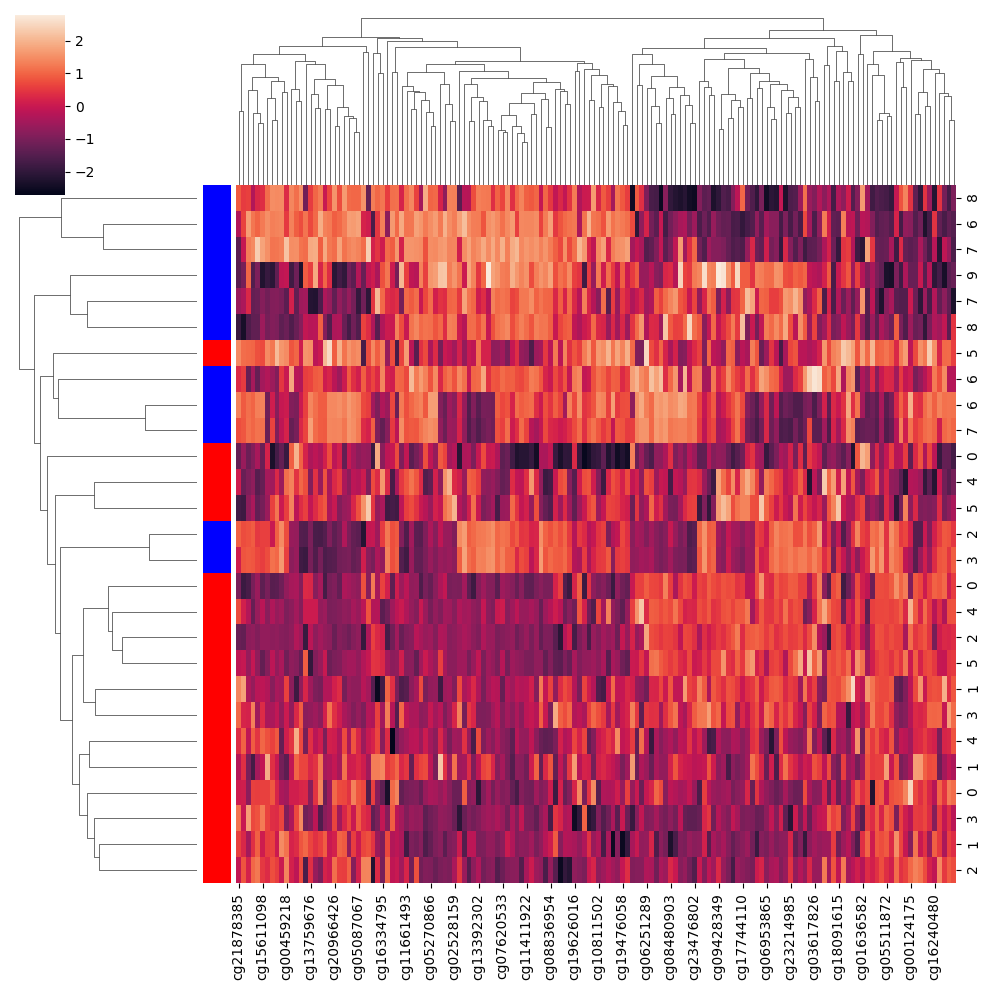

In [ ]:
MergedSenescence = pd.concat([pd.DataFrame(scaler.fit_transform(i), columns=SenescentCPGs) for i in [GSE91069SenVal[SenescentCPGs], GSE131280SenVal[SenescentCPGs],GSE227160SenVal[SenescentCPGs]]])
MergedSenescence['Labels'] = GSE91069SenLab['Label'].tolist() + GSE131280SenLab['B Label'].tolist() + GSE227160SenLab['Label'].tolist()
sns.clustermap(MergedSenescence[SenescentCPGs], row_colors=MergedSenescence['Labels'].map({0:'Red',1:'Blue'}).values)

In [ ]:
model.score(scaler.fit_transform(MergedSenescence[SenescentCPGs].fillna(0)),
            MergedSenescence['Labels'])

0.8518518518518519

In [ ]:
model = LogisticRegression(random_state=42, n_jobs=-1,penalty='l1', solver='saga', tol=1000)
model.fit(X,y)

LogisticRegression(n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                   tol=1000)

In [ ]:
SenescentCPGs = pd.DataFrame(model.coef_[0], index=GSE98440Meth.columns)
SenescentCPGs = SenescentCPGs[SenescentCPGs[0] != 0]
SenescentCPGs = SenescentCPGs.loc[SenescentCPGs[0].abs().sort_values(ascending=False).index]

#### Comparison to Ground Truth

In [ ]:
GSE63577mRNA = pd.read_pickle('Transcriptome/GSE63577.Senescence.pkl')
X = scaler.fit_transform(GSE63577mRNA)
GSE63577MethLabels = pd.read_csv('Transcriptome/GSE63577.Labels.csv')['Senescence']
y = GSE63577MethLabels.copy()

In [ ]:
model = LogisticRegression(random_state=42, n_jobs=-1,penalty='l1', solver='saga', tol=1000)
model.fit(X,y)
cross_val_score(model, X, y, scoring='f1_micro',cv=5,)

array([0.75      , 1.        , 0.85714286, 1.        , 0.57142857])

### Prediction of Age

In [ ]:
# FibroblastTranscriptome = pd.read_csv('Transcriptome/GSE113957_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz', sep='\t', low_memory=False)
# FibroblastTranscriptome = FibroblastTranscriptome.set_index(FibroblastTranscriptome['GeneID'].map(GeneSymbols).values).drop('GeneID',axis=1)
# FibroblastTranscriptome = FibroblastTranscriptome.T
# FibroblastTranscriptome.to_pickle('Transcriptome/FibroblastTranscriptome.pkl')

In [ ]:
# TrainTpm = pd.read_pickle('../GenesBasedPrediction/TrainTpm.pkl')
HorvathCpgs = list(pd.read_table('Transcriptome/Horvath.Cpgs.csv', header=3,sep=',')['(Intercept)'].values)
AgingCpgs = FibroblastMethylation.columns[FibroblastMethylation.columns.isin(HorvathCpgs)]

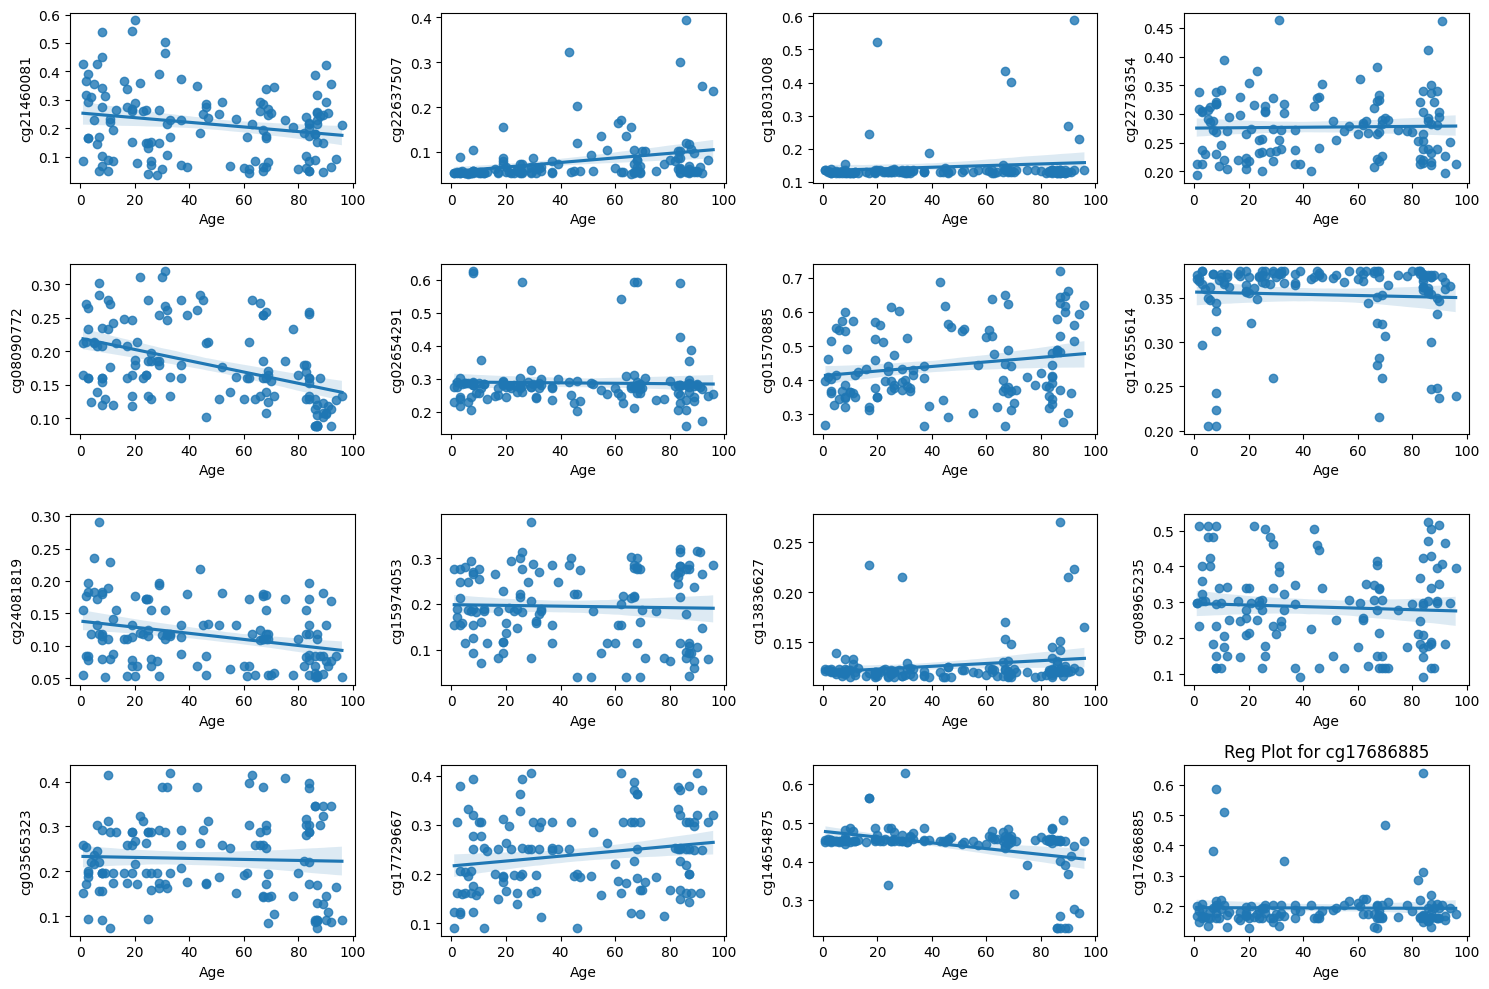

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = list(axes.flatten())
i = 0
for Cpg in AgingCpgs:
    ax = sns.regplot(y=FibroblastMethylation[Cpg], x=FibroblastMethylation['Age'], ax=axes[i])
    plt.title(f'Reg Plot for {Cpg}')
    i += 1
plt.tight_layout()

In [ ]:
# GtexTpm = pd.read_pickle('../GenesBasedPrediction/TrainTpm.pkl')

<Axes: >

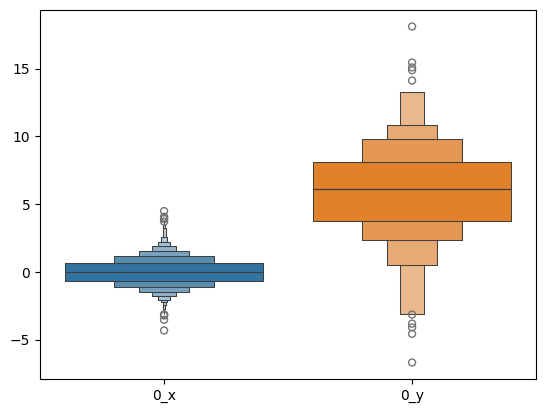

In [ ]:
# sns.boxenplot(pd.merge(TrainTpm[['WASH7P']], FibroblastTranscriptome[['WASH7P']], right_index=True, left_index=True, how='outer'))
# sns.boxenplot(pd.merge(pd.DataFrame(MethScaler.fit_transform(TrainTpm[['WASH7P']])), pd.DataFrame(MethScaler.fit_transform(FibroblastTranscriptome[['WASH7P']])), right_index=True, left_index=True, how='outer'))
sns.boxenplot(pd.merge(pd.DataFrame(MethScaler.fit_transform(GtexTpm[['WASH7P']])), pd.DataFrame(MethScaler.transform(FibroblastTranscriptome[['WASH7P']])), right_index=True, left_index=True, how='outer'))

In [ ]:
# FibroblastMethylation = 
import glob
AllCpgs = glob.glob("Dermal.FibroblastTranscriptomeResults/*.csv")
FibroblastMethylation = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        FibroblastMethylation = pd.concat([FibroblastMethylation, newCSV],axis=1)
    except:pass
FibroblastMethylation = FibroblastMethylation.loc[:,~FibroblastMethylation.columns.duplicated()].copy()
FibroblastMethylation = FibroblastMethylation.set_index('Unnamed: 0')

In [ ]:
# sns.violinplot(FibroblastMethylation[FibroblastMethylation.var().sort_values().tail(5).index])

In [ ]:
FibroblastMeta = pd.read_table('Transcriptome/GSE113957.Meta.txt', sep='\t', header=0)
FibroblastMeta = FibroblastMeta.T[[0,11]].iloc[1:,:]
FibroblastMeta[11] = FibroblastMeta[11].str.replace('age: ','').str.split('yr').str[0].astype(int)

In [ ]:
import numpy as np
FibroblastMethylation['Age'] = FibroblastMethylation.index.map(FibroblastMeta.set_index(0)[11].to_dict()).values
# FibroblastMethylation = FibroblastMethylation.dropna(subset='Age')
FibroblastMethylation['Age'] = FibroblastMethylation['Age'].map(lambda x: 0 if x < 30 else (1 if x > 60 else np.nan))
FibroblastMethylation = FibroblastMethylation.dropna()

/tmp/ipykernel_1710148/829267015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FibroblastMethylation['Age'] = FibroblastMethylation.index.map(FibroblastMeta.set_index(0)[11].to_dict()).values
/tmp/ipykernel_1710148/829267015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FibroblastMethylation['Age'] = FibroblastMethylation['Age'].map(lambda x: 0 if x < 30 else (1 if x > 60 else np.nan))


In [ ]:
from combat.pycombat import pycombat
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split, LeaveOneOut
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, ElasticNetCV, Lasso
from sklearn.metrics import accuracy_score, auc, roc_curve, auc, precision_recall_curve, mean_squared_error, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier , HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from numpy import interp
from sklearn import svm 
import matplotlib.pyplot as plt

scaler = StandardScaler()

In [ ]:
X = scaler.fit_transform(FibroblastMethylation.drop('Age',axis=1))
y = FibroblastMethylation['Age'].values

In [ ]:
model = LogisticRegression(n_jobs=-1, penalty='l2', solver='lbfgs')
model.fit(X,y)

LogisticRegression(n_jobs=-1)

In [ ]:
AgingSelectedCPGs = pd.DataFrame(model.coef_[0], index=FibroblastMethylation.columns[:-1]) #
AgingSelectedCPGs = AgingSelectedCPGs.loc[AgingSelectedCPGs[0].abs().sort_values(ascending=False).head(100).index]
AgingSelectedCPGs[AgingSelectedCPGs.index.isin(HorvathCpgs)]

,0


In [ ]:
sns.clustermap(FibroblastMethylation[AgingSelectedCPGs.index], row_colors=FibroblastMethylation['Age'].map({0:'Red',1:'Blue'}))

In [ ]:
# fig, axes = plt.subplots(4, 4, figsize=(15, 10))
# axes = list(axes.flatten())
# i = 0
# for Cpg in pd.DataFrame(model.coef_, index=FibroblastMethylation.columns[:-1]).sort_values(by=0).tail(10).index:
#     ax = sns.regplot(y=FibroblastMethylation[Cpg], x=FibroblastMethylation['Age'], ax=axes[i])
#     plt.title(f'Reg Plot for {Cpg}')
#     i += 1
# plt.tight_layout()

#### Fibroblast Age Prediction

In [ ]:
# GTexFibroAge = pd.read_csv('Transcriptome/GTExFibroMeta.csv')['AGE'].values
# GTexFibroAge

In [ ]:
import glob
AllCpgs = glob.glob("GTEX.Fibro/GTEX.Fibro*.csv")

GTexFibro = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GTexFibro = pd.concat([GTexFibro, newCSV],axis=1)
    except:pass
GTexFibro = GTexFibro.loc[:,~GTexFibro.columns.duplicated()].copy()
GTexFibro = GTexFibro.set_index('Unnamed: 0')

In [ ]:
X = scaler.fit_transform(GTexFibro.fillna(0))
y = GTexFibroAge

In [ ]:
Train_X ,Test_X,Train_y, Test_y = train_test_split(X, y, test_size=0.4)

In [ ]:
COmparison = []
from sklearn.metrics import accuracy_score, auc, roc_curve, root_mean_squared_error,auc, precision_recall_curve, mean_squared_error, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score,mean_absolute_error, median_absolute_error, r2_score
for i in [0.1,0.5,1, 0.001,0.01, 0.0001, 0.0001]:
    model = Lasso(alpha=i,copy_X=True, )
    model.fit(Train_X, Train_y)
    predicted_test = model.predict(Test_X)
    COmparison.append({'lambda':i, 'RMSE':root_mean_squared_error(predicted_test, Test_y),
                       "MAE":mean_absolute_error(predicted_test, Test_y),
                       "MedAE":median_absolute_error(predicted_test, Test_y),
                       'R2':r2_score(predicted_test, Test_y), 
                       pearsonr(predicted_test, Test_y)})
    print(COmparison)

/home/ansar/projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.562e+00, tolerance: 4.734e+00
  model = cd_fast.enet_coordinate_descent(


[{'lambda': 0.1, 'RMSE': np.float64(11.958921387960942), 'MAE': np.float64(9.324440163683347), 'MedAE': np.float64(7.028535657657486), 'R2': -1.9097440381075916}]
[{'lambda': 0.1, 'RMSE': np.float64(11.958921387960942), 'MAE': np.float64(9.324440163683347), 'MedAE': np.float64(7.028535657657486), 'R2': -1.9097440381075916}, {'lambda': 0.5, 'RMSE': np.float64(11.667693449958296), 'MAE': np.float64(9.288700778728256), 'MedAE': np.float64(7.77076404249258), 'R2': -3.106894305525211}]
[{'lambda': 0.1, 'RMSE': np.float64(11.958921387960942), 'MAE': np.float64(9.324440163683347), 'MedAE': np.float64(7.028535657657486), 'R2': -1.9097440381075916}, {'lambda': 0.5, 'RMSE': np.float64(11.667693449958296), 'MAE': np.float64(9.288700778728256), 'MedAE': np.float64(7.77076404249258), 'R2': -3.106894305525211}, {'lambda': 1, 'RMSE': np.float64(11.946330948849269), 'MAE': np.float64(9.576568090646928), 'MedAE': np.float64(7.78790275808587), 'R2': -5.909713019505382}]


/home/ansar/projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e+01, tolerance: 4.734e+00
  model = cd_fast.enet_coordinate_descent(


[{'lambda': 0.1, 'RMSE': np.float64(11.958921387960942), 'MAE': np.float64(9.324440163683347), 'MedAE': np.float64(7.028535657657486), 'R2': -1.9097440381075916}, {'lambda': 0.5, 'RMSE': np.float64(11.667693449958296), 'MAE': np.float64(9.288700778728256), 'MedAE': np.float64(7.77076404249258), 'R2': -3.106894305525211}, {'lambda': 1, 'RMSE': np.float64(11.946330948849269), 'MAE': np.float64(9.576568090646928), 'MedAE': np.float64(7.78790275808587), 'R2': -5.909713019505382}, {'lambda': 0.001, 'RMSE': np.float64(11.994062269189412), 'MAE': np.float64(9.627568501888252), 'MedAE': np.float64(8.346658070653724), 'R2': -1.137178146002566}]


/home/ansar/projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e+01, tolerance: 4.734e+00
  model = cd_fast.enet_coordinate_descent(


[{'lambda': 0.1, 'RMSE': np.float64(11.958921387960942), 'MAE': np.float64(9.324440163683347), 'MedAE': np.float64(7.028535657657486), 'R2': -1.9097440381075916}, {'lambda': 0.5, 'RMSE': np.float64(11.667693449958296), 'MAE': np.float64(9.288700778728256), 'MedAE': np.float64(7.77076404249258), 'R2': -3.106894305525211}, {'lambda': 1, 'RMSE': np.float64(11.946330948849269), 'MAE': np.float64(9.576568090646928), 'MedAE': np.float64(7.78790275808587), 'R2': -5.909713019505382}, {'lambda': 0.001, 'RMSE': np.float64(11.994062269189412), 'MAE': np.float64(9.627568501888252), 'MedAE': np.float64(8.346658070653724), 'R2': -1.137178146002566}, {'lambda': 0.01, 'RMSE': np.float64(11.869120561576663), 'MAE': np.float64(9.181094609631854), 'MedAE': np.float64(7.344731749074072), 'R2': -1.597060668158}]


/home/ansar/projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.167e+00, tolerance: 4.734e+00
  model = cd_fast.enet_coordinate_descent(


[{'lambda': 0.1, 'RMSE': np.float64(11.958921387960942), 'MAE': np.float64(9.324440163683347), 'MedAE': np.float64(7.028535657657486), 'R2': -1.9097440381075916}, {'lambda': 0.5, 'RMSE': np.float64(11.667693449958296), 'MAE': np.float64(9.288700778728256), 'MedAE': np.float64(7.77076404249258), 'R2': -3.106894305525211}, {'lambda': 1, 'RMSE': np.float64(11.946330948849269), 'MAE': np.float64(9.576568090646928), 'MedAE': np.float64(7.78790275808587), 'R2': -5.909713019505382}, {'lambda': 0.001, 'RMSE': np.float64(11.994062269189412), 'MAE': np.float64(9.627568501888252), 'MedAE': np.float64(8.346658070653724), 'R2': -1.137178146002566}, {'lambda': 0.01, 'RMSE': np.float64(11.869120561576663), 'MAE': np.float64(9.181094609631854), 'MedAE': np.float64(7.344731749074072), 'R2': -1.597060668158}, {'lambda': 0.0001, 'RMSE': np.float64(14.635814429744244), 'MAE': np.float64(11.603385524106322), 'MedAE': np.float64(9.212576485205993), 'R2': -0.8502660028012872}]
[{'lambda': 0.1, 'RMSE': np.flo

/home/ansar/projects/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.167e+00, tolerance: 4.734e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
model = ElasticNetCV(n_jobs=-1,l1_ratio=0.001, n_alphas=10, random_state=42, max_iter=50000)
MeanAbsError = cross_val_score(model, X,y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# np.mean([-9.61747062,  -9.3153655 ,  -7.67942508, -10.16590927,-8.21779123])

KeyboardInterrupt: 

In [ ]:
# GTEXcpgs = pd.DataFrame(model.coef_, index=GTexFibro.columns).sort_values(by=0)
# lasso = ElasticNetCV(l1_ratio= 0.1)

sklearn.linear_model._coordinate_descent.ElasticNetCV

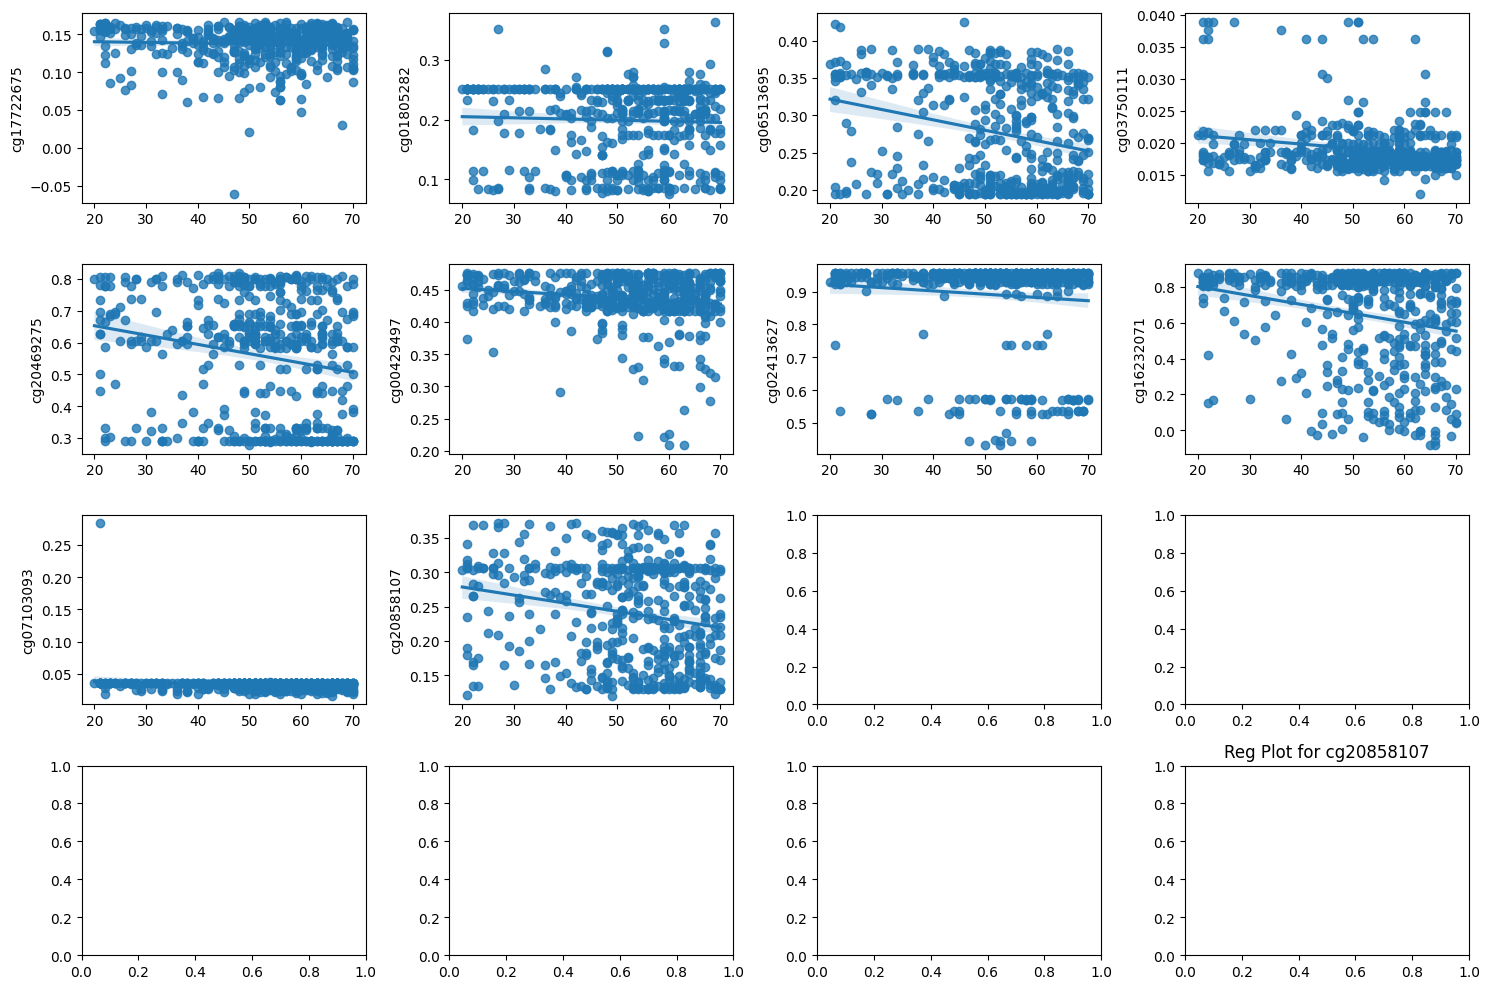

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = list(axes.flatten())
i = 0
for Cpg in GTEXcpgs.head(10).index:
    ax = sns.regplot(y=GTexFibro[Cpg], x=GTexFibroAge, ax=axes[i])
    plt.title(f'Reg Plot for {Cpg}')
    i += 1
plt.tight_layout()

#### Ground Truth: AGE prediction using TPM

In [ ]:
# GTexFibromRNA = pd.read_pickle('Transcriptome/GTExFibroTpm.pkl')

In [ ]:
X = scaler.fit_transform(GTexFibromRNA.T.fillna(0))
y = GTexFibroAge
Train_X ,Test_X,Train_y, Test_y = train_test_split(X, y, test_size=0.4)

In [ ]:
# model = ElasticNetCV(n_jobs=-1, n_alphas=10, random_state=42, max_iter=50000)
# cross_val_score(model, X,y, scoring='median_absolute_error', cv=5, n_jobs=-1)
COmparison = []
from sklearn.metrics import accuracy_score, auc, roc_curve, root_mean_squared_error,auc, precision_recall_curve, mean_squared_error, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score,mean_absolute_error, median_absolute_error, r2_score
for i in [0.1,0.5,1, 0.001,0.01, 0.0001, 0.00001]:
    model = Lasso(alpha=i,copy_X=True, max_iter=5000)
    model.fit(Train_X, Train_y)
    predicted_test = model.predict(Test_X)
    COmparison.append({'lambda':i, 'RMSE':root_mean_squared_error(predicted_test, Test_y),
                       "MAE":mean_absolute_error(predicted_test, Test_y),
                       "MedAE":median_absolute_error(predicted_test, Test_y),
                       'R2':r2_score(predicted_test, Test_y),
                       "Pearson":pearsonr(predicted_test, Test_y)})
    print(COmparison)

[{'lambda': 0.1, 'RMSE': np.float64(11.806954674923132), 'MAE': np.float64(9.307911920943324), 'MedAE': np.float64(7.406682665477234), 'R2': -2.880660118047224, 'Pearson': PearsonRResult(statistic=np.float64(0.40835882221182174), pvalue=np.float64(2.1322040917228286e-09))}]
[{'lambda': 0.1, 'RMSE': np.float64(11.806954674923132), 'MAE': np.float64(9.307911920943324), 'MedAE': np.float64(7.406682665477234), 'R2': -2.880660118047224, 'Pearson': PearsonRResult(statistic=np.float64(0.40835882221182174), pvalue=np.float64(2.1322040917228286e-09))}, {'lambda': 0.5, 'RMSE': np.float64(11.691340138823294), 'MAE': np.float64(9.283207456338326), 'MedAE': np.float64(7.825051906623031), 'R2': -3.668932492015755, 'Pearson': PearsonRResult(statistic=np.float64(0.42408935159557043), pvalue=np.float64(4.32167418537252e-10))}]
[{'lambda': 0.1, 'RMSE': np.float64(11.806954674923132), 'MAE': np.float64(9.307911920943324), 'MedAE': np.float64(7.406682665477234), 'R2': -2.880660118047224, 'Pearson': Pearso